In [1]:
# ================================================================
# Step 0 — Setup: installs, imports, seeds
# ================================================================
!pip -q install kaggle timm scikit-learn tqdm

import os, sys, json, random, shutil, math, glob, time
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models

import timm  # for ViT
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
)
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.6 MB/s eta 0:00:00
Device: cuda


In [2]:
import warnings
warnings.filterwarnings("ignore")


In [3]:
DATA_ROOT = Path("/kaggle/input/3-kinds-of-pneumonia/Curated X-Ray Dataset") 

In [4]:
# ================================================================
# Step 2 — Index images (paths + labels) into a DataFrame
#          (and optionally cap samples/class to keep it light)
# ================================================================
# Expected subfolders (names may have spaces):
# 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral', 'COVID-19'
CLASS_NAMES = sorted([p.name for p in DATA_ROOT.iterdir() if p.is_dir()])
print("Classes:", CLASS_NAMES)
label2idx = {c: i for i, c in enumerate(CLASS_NAMES)}
idx2label = {i: c for c, i in label2idx.items()}

rows = []
for cls in CLASS_NAMES:
    for img_path in (DATA_ROOT/cls).glob("*.*"):
        if img_path.suffix.lower() in [".png", ".jpg", ".jpeg"]:
            rows.append({"path": str(img_path), "label": cls, "y": label2idx[cls]})
df = pd.DataFrame(rows)
print("Total images:", len(df))
df.sample(5)


Classes: ['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']
Total images: 9208


,path,label,y
248,/kaggle/input/3-kinds-of-pneumonia/Curated X-R...,COVID-19,0
2165,/kaggle/input/3-kinds-of-pneumonia/Curated X-R...,Normal,1
6847,/kaggle/input/3-kinds-of-pneumonia/Curated X-R...,Pneumonia-Bacterial,2
4812,/kaggle/input/3-kinds-of-pneumonia/Curated X-R...,Pneumonia-Bacterial,2
2157,/kaggle/input/3-kinds-of-pneumonia/Curated X-R...,Normal,1


In [5]:
# ================================================================
# Step 3 — Create two disjoint "domains" A and B (for cross-dataset validation)
#          Stratified split by label; keep classes balanced across A/B.
#          Optionally cap samples per class to keep runtime small.
# ================================================================
MAX_SAMPLES_PER_CLASS = None  # e.g., 500 to limit CPU time, or None for all

def stratified_cap(df, max_per_class=None):
    if max_per_class is None:
        return df.copy()
    parts = []
    for cls, g in df.groupby("label"):
        parts.append(g.sample(n=min(max_per_class, len(g)), random_state=SEED))
    return pd.concat(parts).reset_index(drop=True)

df_limited = stratified_cap(df, MAX_SAMPLES_PER_CLASS)

# 60/40 split -> A (train domain), B (external domain)
train_A, test_B = train_test_split(
    df_limited, test_size=0.4, stratify=df_limited["y"], random_state=SEED
)
train_B, test_A = train_test_split(
    df_limited, test_size=0.6, stratify=df_limited["y"], random_state=SEED
)  # for symmetry if needed; but we'll derive A/B from the first split

# To be explicit:
A_df = train_A.reset_index(drop=True)     # Domain A
B_df = test_B.reset_index(drop=True)      # Domain B (disjoint from A)

print("Domain A size:", len(A_df), "Domain B size:", len(B_df))
print("A label counts:\n", A_df['label'].value_counts())
print("B label counts:\n", B_df['label'].value_counts())


Domain A size: 5524 Domain B size: 3684
A label counts:
 label
Normal                 1962
Pneumonia-Bacterial    1800
Pneumonia-Viral         993
COVID-19                769
Name: count, dtype: int64
B label counts:
 label
Normal                 1308
Pneumonia-Bacterial    1201
Pneumonia-Viral         663
COVID-19                512
Name: count, dtype: int64


In [6]:
# ================================================================
# Step 4 — Datasets & DataLoaders (with augmentation)
#          ViT & ResNet expect 3-channel 224x224, ImageNet normalization.
# ================================================================
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop((IMG_SIZE, IMG_SIZE), scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

eval_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

class XRayDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["path"]).convert("RGB")  # robust to grayscale
        x = self.transform(img)
        y = int(row["y"])
        return x, y, row["path"]

def make_loader(df, transform, batch_size=16, shuffle=False):
    ds = XRayDataset(df, transform)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=2, pin_memory=False)

# Example loaders for quick tests (real training uses CV below)
tmp_train_loader = make_loader(A_df, train_tfms, shuffle=True)
tmp_val_loader   = make_loader(B_df, eval_tfms, shuffle=False)


In [7]:
# ================================================================
# Step 5 — Models: CNN (DenseNet18), ViT (timm), and Hybrid (concat features)
#          All backbones are FROZEN; only a small classifier is trained.
# ================================================================
def build_densenet121_backbone():
    cnn = models.densenet121(pretrained=True)
    for p in cnn.parameters(): p.requires_grad = False
    # The last layer of DenseNet121 before the classifier is an AdaptiveAvgPool2d followed by a Linear layer.
    # We want the output of the AdaptiveAvgPool2d, which has 1024 features.
    cnn = nn.Sequential(*list(cnn.children())[:-1]) # Remove the last linear layer
    cnn = nn.Sequential(cnn, nn.AdaptiveAvgPool2d((1, 1))) # Add AdaptiveAvgPool2d
    return cnn, 1024 # Output dimension after pooling

def build_vit_backbone():
    vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0, global_pool='avg')
    for p in vit.parameters(): p.requires_grad = False
    # output = 768-dim
    return vit, 768

class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn, cnn_dim = build_densenet121_backbone()
        self.vit, vit_dim = build_vit_backbone()
        self.classifier = nn.Sequential(
            nn.Linear(cnn_dim + vit_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        f_cnn = self.cnn(x)         # [B, 1024, 1, 1]
        f_cnn = torch.flatten(f_cnn, 1) # Flatten to [B, 1024]
        f_vit = self.vit(x)         # [B, 768]
        feats = torch.cat([f_cnn, f_vit], dim=1)
        logits = self.classifier(feats)
        return logits

class CNNOnly(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn, d = build_densenet121_backbone()
        self.classifier = nn.Sequential(
            nn.Flatten(), # Flatten the output of CNN AdaptiveAvgPool2d
            nn.Linear(d, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.cnn(x))

class ViTOnly(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.vit, d = build_vit_backbone()
        self.classifier = nn.Linear(d, num_classes)
    def forward(self, x):
        return self.classifier(self.vit(x))

In [8]:
# ================================================================
# Step 6 — Training & Evaluation utilities
#          Metrics: Acc, Precision/Recall/F1 (macro), AUC (macro & micro)
# ================================================================
def get_optimizer(model, lr=1e-4, weight_decay=0.0):
    # Train only classifier params (frozen backbones)
    params = [p for p in model.parameters() if p.requires_grad]
    return torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)

def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    total_loss = 0.0
    all_y, all_pred, all_prob = [], [], []

    for x, y, _ in loader:
        x, y = x.to(DEVICE), torch.tensor(y).to(DEVICE)
        with torch.set_grad_enabled(is_train):
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            if is_train:
                optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item() * x.size(0)
        probs = F.softmax(logits, dim=1).detach().cpu().numpy()
        preds = probs.argmax(axis=1)
        all_y.extend(y.cpu().numpy().tolist())
        all_pred.extend(preds.tolist())
        all_prob.append(probs)

    all_prob = np.concatenate(all_prob, axis=0)
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, np.array(all_y), np.array(all_pred), all_prob

def compute_metrics(y_true, y_pred, prob, num_classes):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    # Multi-class AUC (one-vs-rest)
    try:
        auc_macro = roc_auc_score(y_true, prob, multi_class='ovr', average='macro')
        auc_micro = roc_auc_score(y_true, prob, multi_class='ovr', average='micro')
    except Exception:
        auc_macro, auc_micro = np.nan, np.nan
    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc_macro": auc_macro, "auc_micro": auc_micro}

def print_metrics(title, metrics):
    print(f"{title} | "
          f"Acc: {metrics['acc']:.4f} | P: {metrics['prec']:.4f} | "
          f"R: {metrics['rec']:.4f} | F1: {metrics['f1']:.4f} | "
          f"AUC(macro): {metrics['auc_macro']:.4f} | AUC(micro): {metrics['auc_micro']:.4f}")

def plot_confusion(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(class_names)), yticks=np.arange(len(class_names)),
        xticklabels=class_names, yticklabels=class_names,
        ylabel='True label', xlabel='Predicted label', title=title
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

def plot_roc_curves(y_true, prob, class_names, title="ROC Curves"):
    # One-vs-rest ROC for each class
    y_true_bin = np.zeros((len(y_true), len(class_names)))
    for i, c in enumerate(y_true):
        y_true_bin[i, c] = 1
    fig = plt.figure(figsize=(6,5))
    for i, cls in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], prob[:, i])
        plt.plot(fpr, tpr, label=f"{cls} (AUC={auc(fpr, tpr):.3f})")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(title); plt.legend()
    plt.show()


In [9]:
# ================================================================
# Step 7 — 5-fold CV inside Domain A (train/val) using Hybrid model
#          (kept light with small EPOCHS_CV)
# ================================================================
BATCH_SIZE = 16
EPOCHS_CV = 4  # keep small for CPU; increase later if you can
NUM_CLASSES = len(CLASS_NAMES)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
fold_metrics = []

X = np.arange(len(A_df))
y = A_df['y'].values

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n===== Fold {fold}/5 =====")
    tr_df = A_df.iloc[tr_idx].reset_index(drop=True)
    va_df = A_df.iloc[va_idx].reset_index(drop=True)

    train_loader = make_loader(tr_df, train_tfms, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = make_loader(va_df, eval_tfms, batch_size=BATCH_SIZE, shuffle=False)

    model = HybridModel(num_classes=NUM_CLASSES).to(DEVICE)
    optim = get_optimizer(model, lr=1e-4)

    best_val = -1
    for ep in range(1, EPOCHS_CV+1):
        tr_loss, tr_y, tr_pred, tr_prob = run_epoch(model, train_loader, optimizer=optim)
        va_loss, va_y, va_pred, va_prob = run_epoch(model, val_loader, optimizer=None)

        tr_m = compute_metrics(tr_y, tr_pred, tr_prob, NUM_CLASSES)
        va_m = compute_metrics(va_y, va_pred, va_prob, NUM_CLASSES)
        print(f"Epoch {ep}: train loss {tr_loss:.4f} | val loss {va_loss:.4f}")
        print_metrics("  Train", tr_m); print_metrics("  Val  ", va_m)

        score = va_m['f1']
        if score > best_val:
            best_val = score
            torch.save(model.state_dict(), f"cv_fold{fold}_best.pth")

    # record final fold val metrics (last epoch)
    fold_metrics.append(va_m)

print("\n=== CV Results (A-domain) averaged over folds ===")
avg = {k: float(np.nanmean([m[k] for m in fold_metrics])) for k in fold_metrics[0].keys()}
print_metrics("CV(A)", avg)



===== Fold 1/5 =====


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 136MB/s]


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1: train loss 0.7288 | val loss 0.5381
  Train | Acc: 0.7248 | P: 0.7140 | R: 0.6722 | F1: 0.6750 | AUC(macro): 0.8919 | AUC(micro): 0.9154
  Val   | Acc: 0.7910 | P: 0.8077 | R: 0.7235 | F1: 0.7087 | AUC(macro): 0.9345 | AUC(micro): 0.9498
Epoch 2: train loss 0.5094 | val loss 0.4581
  Train | Acc: 0.8081 | P: 0.7995 | R: 0.7814 | F1: 0.7838 | AUC(macro): 0.9339 | AUC(micro): 0.9553
  Val   | Acc: 0.8244 | P: 0.8266 | R: 0.7823 | F1: 0.7826 | AUC(macro): 0.9439 | AUC(micro): 0.9627
Epoch 3: train loss 0.4774 | val loss 0.4755
  Train | Acc: 0.8129 | P: 0.8033 | R: 0.7870 | F1: 0.7899 | AUC(macro): 0.9394 | AUC(micro): 0.9596
  Val   | Acc: 0.7973 | P: 0.7876 | R: 0.7890 | F1: 0.7852 | AUC(macro): 0.9433 | AUC(micro): 0.9591
Epoch 4: train loss 0.4466 | val loss 0.4508
  Train | Acc: 0.8190 | P: 0.8096 | R: 0.7957 | F1: 0.7990 | AUC(macro): 0.9447 | AUC(micro): 0.9644
  Val   | Acc: 0.8253 | P: 0.8261 | R: 0.7809 | F1: 0.7746 | AUC(macro): 0.9472 | AUC(micro): 0.9650

===== Fold 


===== A→B: Train on 5524, Test on 3684 =====
Epoch 1: train loss 0.6728
  Train | Acc: 0.7478 | P: 0.7436 | R: 0.6991 | F1: 0.7024 | AUC(macro): 0.9049 | AUC(micro): 0.9276
Epoch 2: train loss 0.4883
  Train | Acc: 0.8054 | P: 0.7928 | R: 0.7806 | F1: 0.7813 | AUC(macro): 0.9367 | AUC(micro): 0.9581
Epoch 3: train loss 0.4516
  Train | Acc: 0.8204 | P: 0.8098 | R: 0.7954 | F1: 0.7977 | AUC(macro): 0.9434 | AUC(micro): 0.9636
Epoch 4: train loss 0.4391
  Train | Acc: 0.8190 | P: 0.8083 | R: 0.7938 | F1: 0.7965 | AUC(macro): 0.9443 | AUC(micro): 0.9650
Epoch 5: train loss 0.4298
  Train | Acc: 0.8302 | P: 0.8203 | R: 0.8094 | F1: 0.8117 | AUC(macro): 0.9471 | AUC(micro): 0.9665
External Test | Acc: 0.8341 | P: 0.8410 | R: 0.7971 | F1: 0.8017 | AUC(macro): 0.9488 | AUC(micro): 0.9668


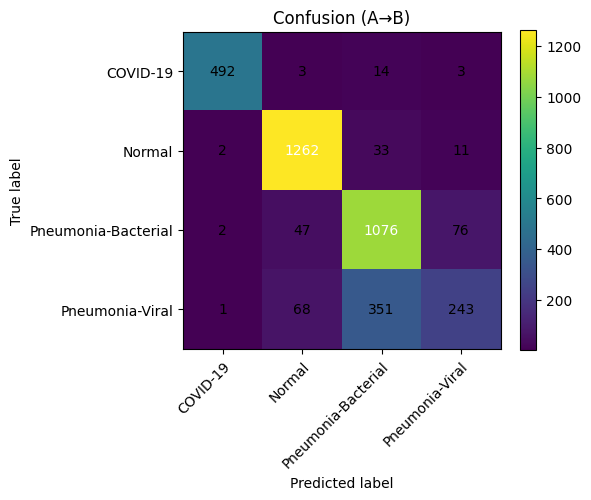

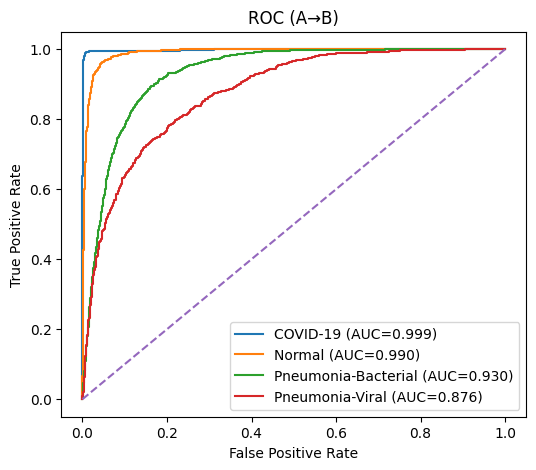


Per-class report:
                     precision    recall  f1-score   support

           COVID-19       0.99      0.96      0.98       512
             Normal       0.91      0.96      0.94      1308
Pneumonia-Bacterial       0.73      0.90      0.80      1201
    Pneumonia-Viral       0.73      0.37      0.49       663

           accuracy                           0.83      3684
          macro avg       0.84      0.80      0.80      3684
       weighted avg       0.83      0.83      0.82      3684


===== B→A: Train on 3684, Test on 5524 =====
Epoch 1: train loss 0.7421
  Train | Acc: 0.7177 | P: 0.7106 | R: 0.6670 | F1: 0.6648 | AUC(macro): 0.8914 | AUC(micro): 0.9148
Epoch 2: train loss 0.5238
  Train | Acc: 0.7961 | P: 0.7855 | R: 0.7670 | F1: 0.7691 | AUC(macro): 0.9300 | AUC(micro): 0.9528
Epoch 3: train loss 0.4667
  Train | Acc: 0.8149 | P: 0.8058 | R: 0.7938 | F1: 0.7955 | AUC(macro): 0.9410 | AUC(micro): 0.9618
Epoch 4: train loss 0.4635
  Train | Acc: 0.8179 | P: 0.8098

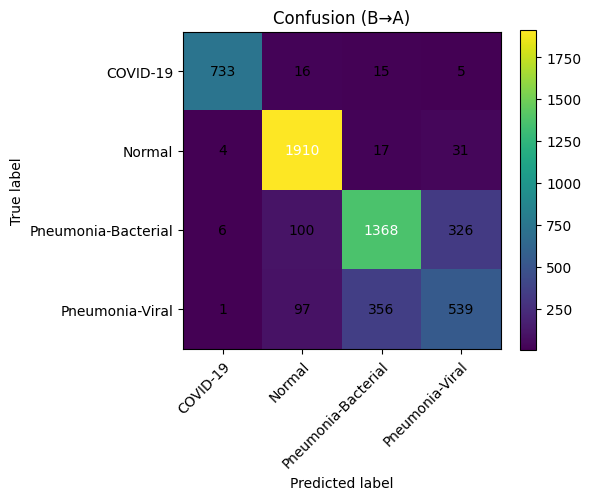

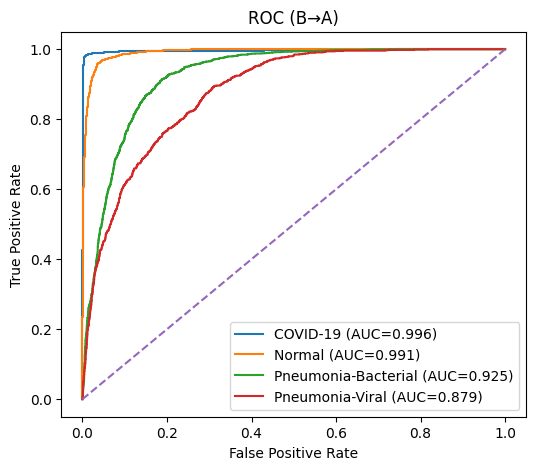


Per-class report:
                     precision    recall  f1-score   support

           COVID-19       0.99      0.95      0.97       769
             Normal       0.90      0.97      0.94      1962
Pneumonia-Bacterial       0.78      0.76      0.77      1800
    Pneumonia-Viral       0.60      0.54      0.57       993

           accuracy                           0.82      5524
          macro avg       0.82      0.81      0.81      5524
       weighted avg       0.82      0.82      0.82      5524



In [10]:
# ================================================================
# Step 8 — External Generalization:
#          Train on ALL of A, evaluate on B (external), then swap (B→A)
# ================================================================
def train_full_and_eval(train_df, test_df, model_cls=HybridModel,
                        epochs=3, title="A->B"):
    print(f"\n===== {title}: Train on {len(train_df)}, Test on {len(test_df)} =====")
    train_loader = make_loader(train_df, train_tfms, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = make_loader(test_df,  eval_tfms,   batch_size=BATCH_SIZE, shuffle=False)

    model = model_cls(num_classes=NUM_CLASSES).to(DEVICE)
    optim = get_optimizer(model, lr=1e-4)

    for ep in range(1, epochs+1):
        tr_loss, tr_y, tr_pred, tr_prob = run_epoch(model, train_loader, optimizer=optim)
        tr_m = compute_metrics(tr_y, tr_pred, tr_prob, NUM_CLASSES)
        print(f"Epoch {ep}: train loss {tr_loss:.4f}")
        print_metrics("  Train", tr_m)

    # External test
    te_loss, te_y, te_pred, te_prob = run_epoch(model, test_loader, optimizer=None)
    te_m = compute_metrics(te_y, te_pred, te_prob, NUM_CLASSES)
    print_metrics("External Test", te_m)
    plot_confusion(te_y, te_pred, CLASS_NAMES, title=f"Confusion ({title})")
    plot_roc_curves(te_y, te_prob, CLASS_NAMES, title=f"ROC ({title})")

    print("\nPer-class report:")
    print(classification_report(te_y, te_pred, target_names=CLASS_NAMES, zero_division=0))
    return model, (te_y, te_pred, te_prob), te_m

EPOCHS_FULL = 5  # light; increase if you can

# Train on A, test on B
model_A2B, (y_B, pred_B, prob_B), m_A2B = train_full_and_eval(A_df, B_df, HybridModel, EPOCHS_FULL, "A→B")

# Train on B, test on A (swap)
model_B2A, (y_A, pred_A, prob_A), m_B2A = train_full_and_eval(B_df, A_df, HybridModel, EPOCHS_FULL, "B→A")



===== CNN-only A→B: Train on 5524, Test on 3684 =====
Epoch 1: train loss 1.0353
  Train | Acc: 0.6115 | P: 0.5872 | R: 0.5306 | F1: 0.5159 | AUC(macro): 0.8201 | AUC(micro): 0.8356
Epoch 2: train loss 0.7555
  Train | Acc: 0.7391 | P: 0.7369 | R: 0.6880 | F1: 0.6874 | AUC(macro): 0.9025 | AUC(micro): 0.9218
Epoch 3: train loss 0.6593
  Train | Acc: 0.7639 | P: 0.7549 | R: 0.7246 | F1: 0.7259 | AUC(macro): 0.9167 | AUC(micro): 0.9367
Epoch 4: train loss 0.6198
  Train | Acc: 0.7730 | P: 0.7635 | R: 0.7393 | F1: 0.7393 | AUC(macro): 0.9209 | AUC(micro): 0.9405
Epoch 5: train loss 0.5984
  Train | Acc: 0.7782 | P: 0.7647 | R: 0.7454 | F1: 0.7456 | AUC(macro): 0.9224 | AUC(micro): 0.9429
External Test | Acc: 0.8016 | P: 0.7975 | R: 0.7690 | F1: 0.7753 | AUC(macro): 0.9313 | AUC(micro): 0.9506


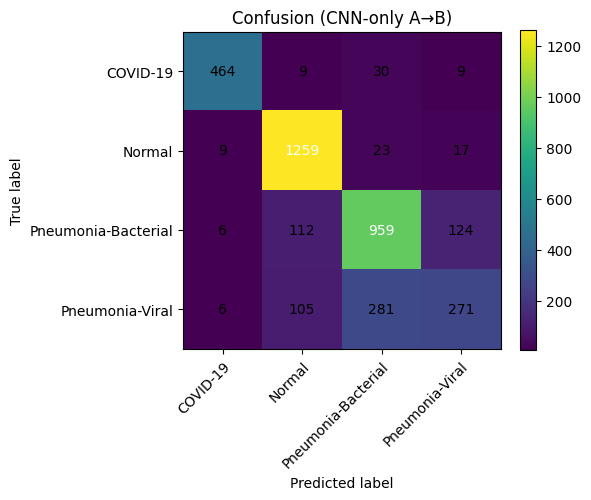

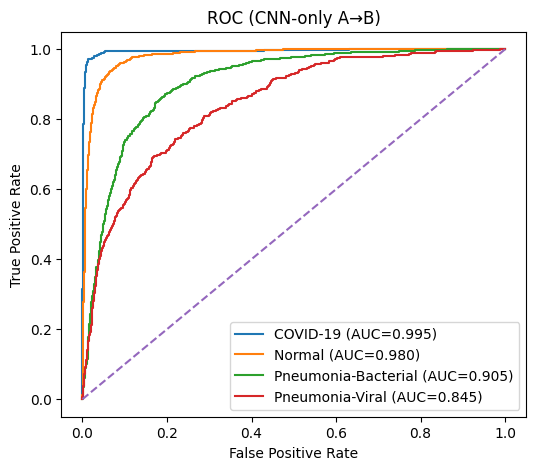


Per-class report:
                     precision    recall  f1-score   support

           COVID-19       0.96      0.91      0.93       512
             Normal       0.85      0.96      0.90      1308
Pneumonia-Bacterial       0.74      0.80      0.77      1201
    Pneumonia-Viral       0.64      0.41      0.50       663

           accuracy                           0.80      3684
          macro avg       0.80      0.77      0.78      3684
       weighted avg       0.79      0.80      0.79      3684


===== ViT-only A→B: Train on 5524, Test on 3684 =====
Epoch 1: train loss 1.1885
  Train | Acc: 0.5223 | P: 0.3985 | R: 0.4120 | F1: 0.3722 | AUC(macro): 0.7502 | AUC(micro): 0.7497
Epoch 2: train loss 0.9126
  Train | Acc: 0.6993 | P: 0.7314 | R: 0.6130 | F1: 0.5864 | AUC(macro): 0.8901 | AUC(micro): 0.8917
Epoch 3: train loss 0.7892
  Train | Acc: 0.7397 | P: 0.7542 | R: 0.6764 | F1: 0.6561 | AUC(macro): 0.9076 | AUC(micro): 0.9216
Epoch 4: train loss 0.7128
  Train | Acc: 0.7534 | 

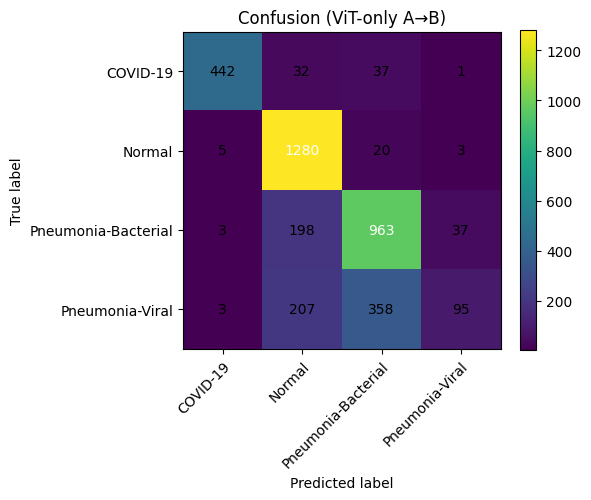

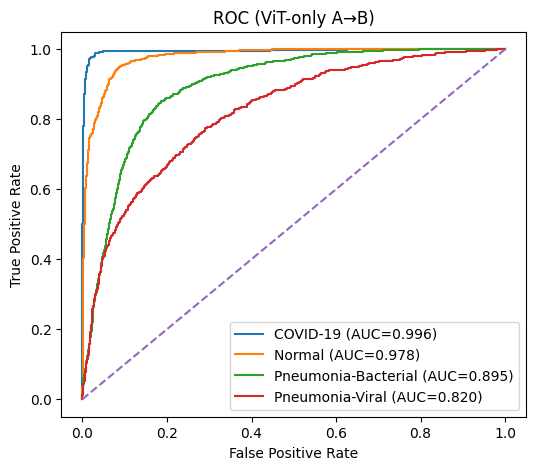


Per-class report:
                     precision    recall  f1-score   support

           COVID-19       0.98      0.86      0.92       512
             Normal       0.75      0.98      0.85      1308
Pneumonia-Bacterial       0.70      0.80      0.75      1201
    Pneumonia-Viral       0.70      0.14      0.24       663

           accuracy                           0.75      3684
          macro avg       0.78      0.70      0.69      3684
       weighted avg       0.75      0.75      0.71      3684


=== Summary: External Test (A→B) ===
Hybrid | Acc: 0.8341 | P: 0.8410 | R: 0.7971 | F1: 0.8017 | AUC(macro): 0.9488 | AUC(micro): 0.9668
CNN-only | Acc: 0.8016 | P: 0.7975 | R: 0.7690 | F1: 0.7753 | AUC(macro): 0.9313 | AUC(micro): 0.9506
ViT-only | Acc: 0.7546 | P: 0.7796 | R: 0.6967 | F1: 0.6867 | AUC(macro): 0.9222 | AUC(micro): 0.9327


In [11]:
# ================================================================
# Step 9 — Baselines: CNN-only and ViT-only (train on A, test on B)
#          (to show hybrid improvement)
# ================================================================
cnn_model, (_, _, _), m_cnn = train_full_and_eval(A_df, B_df, CNNOnly,  epochs=EPOCHS_FULL, title="CNN-only A→B")
vit_model, (_, _, _), m_vit = train_full_and_eval(A_df, B_df, ViTOnly,  epochs=EPOCHS_FULL, title="ViT-only A→B")

print("\n=== Summary: External Test (A→B) ===")
for name, m in [("Hybrid", m_A2B), ("CNN-only", m_cnn), ("ViT-only", m_vit)]:
    print_metrics(name, m)


In [12]:
# ================================================================
# Step 10 — Grad-CAM (CNN branch) for interpretability
#           We visualize top-1 prediction attention on DenseNet norm5 layer.
# ================================================================
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# Assume these variables are defined elsewhere in the notebook
# B_df, SEED, model_A2B, eval_tfms, IMG_SIZE, DEVICE, idx2label

def gradcam_densenet121(model_hybrid, img_tensor, target_class=None):
    """
    img_tensor: [1, 3, 224, 224] (already normalized)
    Returns heatmap (H, W) in [0,1]
    """
    model_hybrid.eval()
    cnn = model_hybrid.cnn  # DenseNet121 backbone (Sequential: features -> AdaptiveAvgPool2d)

    # We'll perform the forward pass in two parts to capture gradients correctly.
    features_extractor = cnn[0] # The 'features' part of DenseNet
    classifier = model_hybrid.classifier # The final classifier layers

    # Define the target layer for Grad-CAM
    conv_layer = features_extractor[-1]

    activations = []
    gradients = []

    def fwd_hook(module, inp, out):
        activations.append(out) # out.detach() removed to allow gradient calculation
    def bwd_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    # Register the hooks
    h1 = conv_layer.register_forward_hook(fwd_hook)
    h2 = conv_layer.register_backward_hook(bwd_hook)

    # Forward pass
    img_tensor = img_tensor.to(DEVICE)
    features = features_extractor(img_tensor)

    # Detach features from the graph to avoid memory issues and unnecessary gradient calculations
    features = features.detach().requires_grad_()

    # Pass the features through the classifier
    logits = classifier(features)

    # Determine the target class if not provided
    if target_class is None:
        target_class = logits.argmax(dim=1)

    # Compute loss for the target class and perform backward pass
    loss = logits[:, target_class].sum()
    model_hybrid.zero_grad() # Zero all gradients before the backward pass
    loss.backward()

    # Compute Grad-CAM on captured maps
    fmap = activations[0]       # [B, C, H, W]
    grads = gradients[0]        # [B, C, H, W]
    weights = grads.mean(dim=(2,3), keepdim=True)  # [B, C, 1, 1]
    cam = (weights * fmap).sum(dim=1, keepdim=True)  # [B, 1, H, W]
    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    heatmap = cam[0,0].detach().cpu().numpy()

    # Cleanup hooks
    h1.remove(); h2.remove()
    return heatmap, int(target_class.item())

In [13]:
def compare_models_on_external(test_df, models_dict, batch_size=16):
    """
    models_dict: dict of {name: model_instance}
    test_df: DataFrame with 'path' and 'y' columns
    """
    results = {}
    test_loader = make_loader(test_df, eval_tfms, batch_size=batch_size, shuffle=False)

    for name, model in models_dict.items():
        model.eval()
        _, y_true, y_pred, y_prob = run_epoch(model, test_loader, optimizer=None)
        metrics = compute_metrics(y_true, y_pred, y_prob, NUM_CLASSES)
        results[name] = metrics
        print(f"\n--- {name} ---")
        print_metrics("External Test", metrics)

    return results


In [14]:
models_to_compare = {
    "Hybrid": model_A2B,
    "CNN-only": cnn_model,
    "ViT-only": vit_model
}

results = compare_models_on_external(B_df, models_to_compare)



--- Hybrid ---
External Test | Acc: 0.8341 | P: 0.8410 | R: 0.7971 | F1: 0.8017 | AUC(macro): 0.9488 | AUC(micro): 0.9668

--- CNN-only ---
External Test | Acc: 0.8016 | P: 0.7975 | R: 0.7690 | F1: 0.7753 | AUC(macro): 0.9313 | AUC(micro): 0.9506

--- ViT-only ---
External Test | Acc: 0.7546 | P: 0.7796 | R: 0.6967 | F1: 0.6867 | AUC(macro): 0.9222 | AUC(micro): 0.9327


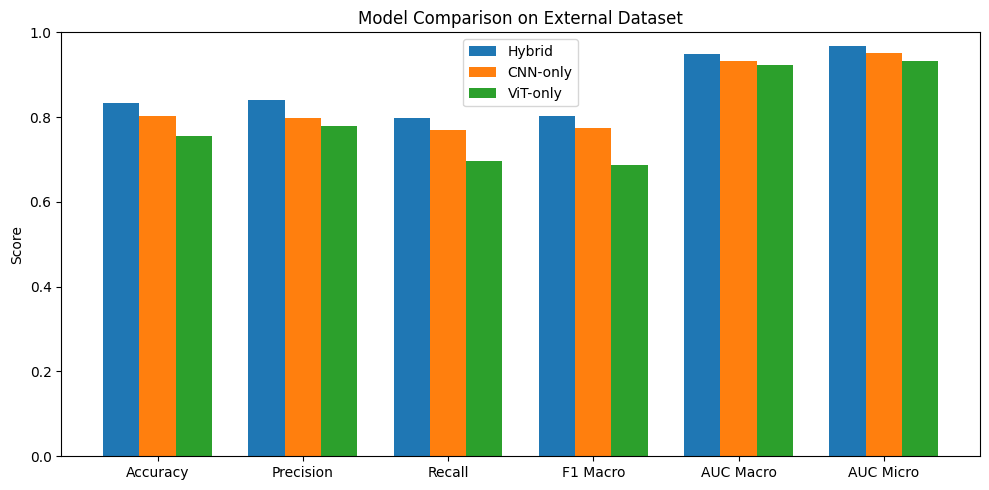

In [15]:
import matplotlib.pyplot as plt
import numpy as np

metrics_to_plot = ["acc", "prec", "rec", "f1", "auc_macro", "auc_micro"]
metric_labels = ["Accuracy", "Precision", "Recall", "F1 Macro", "AUC Macro", "AUC Micro"]

models = list(results.keys())
num_metrics = len(metrics_to_plot)
num_models = len(models)

# Prepare data
data = np.array([[results[m][metric] for metric in metrics_to_plot] for m in models])  # shape: (3,6)

x = np.arange(num_metrics)  # one position per metric
width = 0.25  # width of each bar

fig, ax = plt.subplots(figsize=(10,5))

# Plot each model
for i, model_name in enumerate(models):
    ax.bar(x + i*width - width, data[i], width, label=model_name)

ax.set_xticks(x)
ax.set_xticklabels(metric_labels)
ax.set_ylim(0,1)
ax.set_ylabel("Score")
ax.set_title("Model Comparison on External Dataset")
ax.legend()
plt.tight_layout()
plt.show()


In [16]:
# Set up Kaggle credentials (same style as earlier cells)
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# # Download & unzip the external dataset (same CLI style as earlier cells)
# !mkdir -p ./pneumonia_extra
# !kaggle datasets download -d kostasdiamantaras/chest-xrays-bacterial-viral-pneumonia-normal -p ./pneumonia_extra
# !unzip -q ./pneumonia_extra/chest-xrays-bacterial-viral-pneumonia-normal.zip -d ./pneumonia_extra

In [17]:
# Cell 4 - index extra Kaggle dataset (pneumonia_extra)
from pathlib import Path # Import Path here
import pandas as pd # Import pandas here

# Define label2idx and CLASS_NAMES (assuming these are consistent with your project)
# You might need to adjust CLASS_NAMES if the extra dataset has different classes
CLASS_NAMES = ['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral'] # Example, adjust if needed
label2idx = {c: i for i, c in enumerate(CLASS_NAMES)}


BASE2 = Path("/kaggle/input/chest-xrays-bacterial-viral-pneumonia-normal")
train_folder = BASE2 / "train_images/train_images"
test_folder  = BASE2 / "test_images/test_images"

rows2 = []
def add_from_folder(folder, rows):
    p = Path(folder)
    if not p.exists():
        return
    for img in p.glob("*.*"):   # <-- changed from "." to "*.*"
        if img.suffix.lower() in [".png", ".jpg", ".jpeg"]:
            rows.append({"path": str(img), "fname": img.name})
add_from_folder(train_folder, rows2)
add_from_folder(test_folder, rows2)

extra_df = pd.DataFrame(rows2)
print("Found images in extra dataset:", len(extra_df))

# try to load labels CSV for train images (labels_train.csv might exist)
labels_csv_candidates = list(BASE2.glob("*.csv")) + list(BASE2.glob("**/labels.csv"))
labels_csv = labels_csv_candidates[0] if labels_csv_candidates else None
if labels_csv is not None and labels_csv.exists():
    lab = pd.read_csv(labels_csv)
    # dataset documentation: class_id: 0=normal,1=bacterial,2=viral
    id2name = {0: "Normal", 1: "Pneumonia-Bacterial", 2: "Pneumonia-Viral"}
    extra_df = extra_df.merge(lab, left_on="fname", right_on="file_name", how="left")
    extra_df['label'] = extra_df['class_id'].map(id2name)
    # map to your project's label indices (some datasets may not contain COVID-19)
    extra_df['y'] = extra_df['label'].map(label2idx)
else:
    # If labels CSV not found but folder has class subfolders, try to infer
    print("labels CSV not found automatically. Attempting folder-structure mapping...")
    rows3 = []
    for sub in BASE2.iterdir():
        if sub.is_dir():
            for img in sub.glob("*.*"):
                if img.suffix.lower() in [".png",".jpg",".jpeg"]:
                    label_name = sub.name
                    mapped = label2idx.get(label_name, None)
                    if mapped is not None:
                        rows3.append({"path": str(img), "label": label_name, "y": mapped})
    if len(rows3) > 0:
        extra_df = pd.DataFrame(rows3)
    else:
        print("Could not detect labels automatically for extra dataset. Please provide labels CSV or folder mapping.")

extra_df = extra_df.dropna(subset=['y']).reset_index(drop=True)
print("Extra dataset final counts:\n", extra_df['label'].value_counts())
extra_df.head()

Found images in extra dataset: 5840
Extra dataset final counts:
 label
Pneumonia-Bacterial    2238
Normal                 1227
Pneumonia-Viral        1207
Name: count, dtype: int64


,path,fname,file_name,class_id,label,y
0,/kaggle/input/chest-xrays-bacterial-viral-pneu...,img_1111413058850641317.jpg,img_1111413058850641317.jpg,1.0,Pneumonia-Bacterial,2.0
1,/kaggle/input/chest-xrays-bacterial-viral-pneu...,img_4469873077794821816.jpg,img_4469873077794821816.jpg,0.0,Normal,1.0
2,/kaggle/input/chest-xrays-bacterial-viral-pneu...,img_1800581083463053059.jpg,img_1800581083463053059.jpg,1.0,Pneumonia-Bacterial,2.0
3,/kaggle/input/chest-xrays-bacterial-viral-pneu...,img_7111635913473067290.jpg,img_7111635913473067290.jpg,1.0,Pneumonia-Bacterial,2.0
4,/kaggle/input/chest-xrays-bacterial-viral-pneu...,img_2745491048100369781.jpg,img_2745491048100369781.jpg,2.0,Pneumonia-Viral,3.0


In [18]:
# ==== Build external loader + minimal fallbacks if needed ====
import torch, numpy as np, pandas as pd
from pathlib import Path

# DEVICE fallback
if 'DEVICE' not in globals():
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# NUM_CLASSES fallback
if 'NUM_CLASSES' not in globals():
    if 'CLASS_NAMES' in globals():
        NUM_CLASSES = len(CLASS_NAMES)
    else:
        NUM_CLASSES = 3  # default to 3 (Normal/Bacterial/Viral)

# eval_tfms / dataset / loader fallbacks (only if missing)
try:
    _ = eval_tfms
    _ = XRayDataset
    _ = make_loader
except NameError:
    import torch.nn.functional as F
    from torch.utils.data import Dataset, DataLoader
    from torchvision import transforms
    from PIL import Image

    if 'IMG_SIZE' not in globals(): IMG_SIZE = 224
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD  = [0.229, 0.224, 0.225]
    eval_tfms = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

    class XRayDataset(Dataset):
        def __init__(self, df, transform=None):
            self.df = df.reset_index(drop=True); self.transform = transform
        def __len__(self): return len(self.df)
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            x = Image.open(row['path']).convert('RGB')
            x = self.transform(x) if self.transform else transforms.ToTensor()(x)
            y = int(row['y'])
            return x, y

    def make_loader(df, transform, batch_size=16, shuffle=False, num_workers=2):
        return DataLoader(XRayDataset(df, transform), batch_size=batch_size, shuffle=shuffle,
                          num_workers=num_workers, pin_memory=False)

# simple metrics + run_epoch fallbacks (only if missing)
try:
    _ = compute_metrics
    _ = run_epoch
except NameError:
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

    def compute_metrics(y_true, y_pred, y_prob, num_classes:int):
        y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
        acc = float(accuracy_score(y_true, y_pred))
        prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
        auc_ovr = np.nan; auc_macro = np.nan; auc_micro = np.nan
        try:
            y_prob = np.asarray(y_prob)
            if y_prob.ndim == 2 and y_prob.shape[1] >= 2:
                auc_ovr   = float(roc_auc_score(y_true, y_prob, multi_class='ovr'))
                auc_macro = float(roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro'))
                auc_micro = float(roc_auc_score(y_true, y_prob, multi_class='ovr', average='micro'))
        except Exception:
            pass
        return {"acc": acc, "precision": float(prec), "recall": float(rec), "f1": float(f1),
                "auc_ovr": auc_ovr, "auc_macro": auc_macro, "auc_micro": auc_micro}

    @torch.no_grad()
    def run_epoch(model, loader, optimizer=None):
        model.eval()
        all_y, all_pred, all_prob = [], [], []
        for x, y in loader:
            x = x.to(DEVICE)
            logits = model(x)
            if logits.ndim == 1: logits = logits.unsqueeze(1)
            if logits.shape[1] == 1:
                # binary -> make 2-class probs
                prob1 = torch.sigmoid(logits).cpu().numpy()
                probs = np.concatenate([1 - prob1, prob1], axis=1)
            else:
                probs = torch.softmax(logits, dim=1).cpu().numpy()
            preds = probs.argmax(axis=1)
            all_y.extend(y.numpy().tolist())
            all_pred.extend(preds.tolist())
            all_prob.extend(probs.tolist())
        return 0.0, np.array(all_y), np.array(all_pred), np.array(all_prob)

# make the external DataLoader
assert 'extra_df' in globals() and len(extra_df) > 0, "extra_df is missing — run your indexing cell first."
if 'BATCH_SIZE' not in globals(): BATCH_SIZE = 16
external_loader = make_loader(extra_df, eval_tfms, batch_size=BATCH_SIZE, shuffle=False)
print(f"External loader ready with {len(extra_df)} images. DEVICE={DEVICE}, NUM_CLASSES={NUM_CLASSES}")


External loader ready with 4672 images. DEVICE=cuda, NUM_CLASSES=4


In [19]:
# ==== Models: DenseNet121, ViT-B/16, and the Hybrid (concat features -> linear head) ====
import torch, torch.nn as nn
from torchvision import models
import timm

def build_densenet121_backbone():
    cnn = models.densenet121(pretrained=True)  # same as your training cell
    for p in cnn.parameters():
        p.requires_grad = False
    # remove top classifier, keep features, then add adaptive pool to (1,1)
    cnn = nn.Sequential(*list(cnn.children())[:-1])
    cnn = nn.Sequential(cnn, nn.AdaptiveAvgPool2d((1, 1)))
    return cnn, 1024  # DenseNet121 feature dim

def build_vit_backbone():
    # ViT-B/16 with global average pooling to a 768-dim vector
    vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0, global_pool='avg')
    for p in vit.parameters():
        p.requires_grad = False
    d = vit.num_features if hasattr(vit, "num_features") else 768
    return vit, d

class CNNOnly(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn, d = build_densenet121_backbone()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(d, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.cnn(x))

class ViTOnly(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.vit, d = build_vit_backbone()
        self.classifier = nn.Linear(d, num_classes)
    def forward(self, x):
        return self.classifier(self.vit(x))

class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn, d_cnn = build_densenet121_backbone()
        self.vit, d_vit = build_vit_backbone()
        self.classifier = nn.Linear(d_cnn + d_vit, num_classes)  # simple linear head (matches typical training)
    def forward(self, x):
        f_cnn = self.cnn(x)                # (B,1024,1,1)
        f_cnn = torch.flatten(f_cnn, 1)    # (B,1024)
        f_vit = self.vit(x)                # (B,768)
        f = torch.cat([f_cnn, f_vit], dim=1)
        return self.classifier(f)


In [20]:
# Select device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_A2B.to(device)

In [21]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch

# Select device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# --- Step 1: Define transforms (same as training) ---
test_transform = transforms.Compose([
    transforms.Resize((224,224)),   # change if your model uses a different size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Step 2: Dataset class for extra_df ---
class ExtraDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        label = self.df.iloc[idx]['y']
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# --- Step 3: DataLoader ---
extra_dataset = ExtraDataset(extra_df, transform=test_transform)
extra_loader = DataLoader(extra_dataset, batch_size=32, shuffle=False)

# --- Step 4: Evaluate ---
model.eval()
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in extra_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Accuracy on extra dataset: {100*correct/total:.2f}%")


Accuracy on extra dataset: 78.34%



Classification Report:
                     precision    recall  f1-score   support

           COVID-19       0.00      0.00      0.00         0
             Normal       0.86      0.95      0.90      1227
Pneumonia-Bacterial       0.74      0.92      0.82      2238
    Pneumonia-Viral       0.81      0.36      0.50      1207

           accuracy                           0.78      4672
          macro avg       0.60      0.56      0.56      4672
       weighted avg       0.79      0.78      0.76      4672



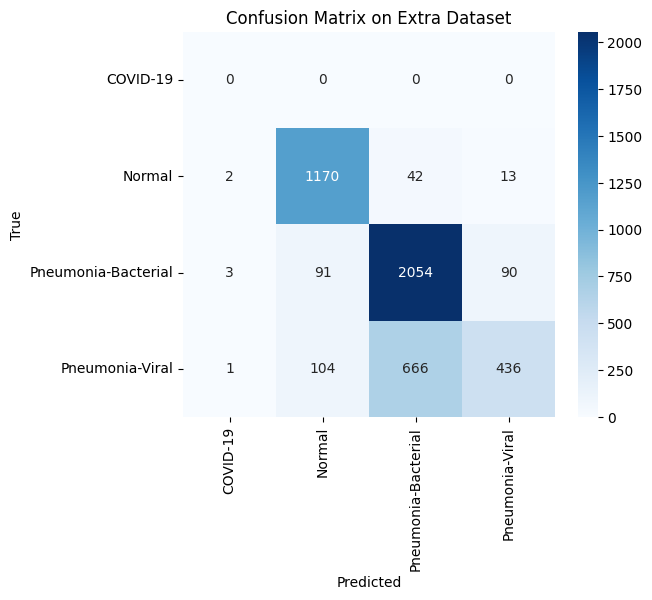

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Extra Dataset")
plt.show()
